['test-case-1000', 'test-case-1000/coreg_input', 'test-case-1000/coreg_output', 'test-case-1000/ml_output', 'test-case-1000/ml_input', 'test-case-1000/convergence_data', 'test-case-1000/tmp/']
reconstructing at 0 Ma...


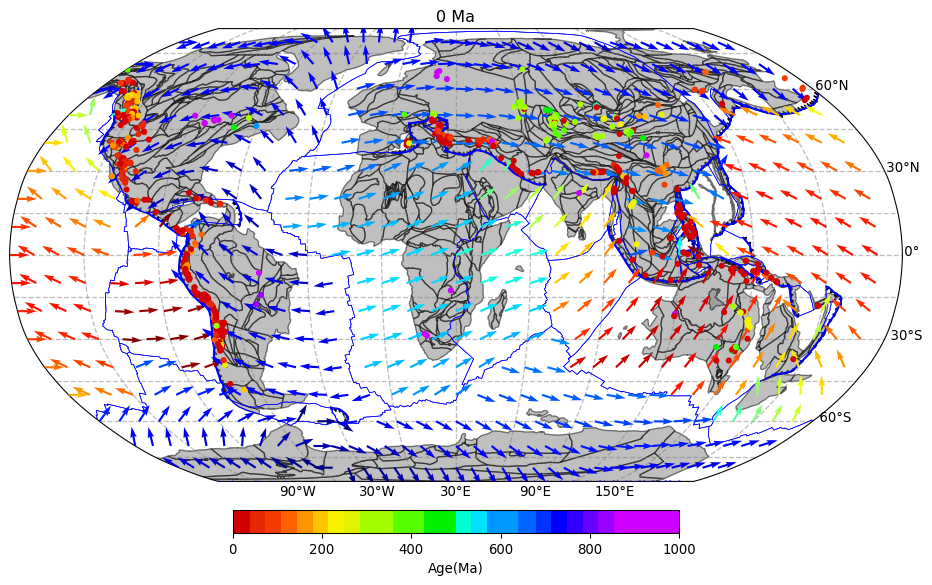

plotting 0Ma


In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
from netCDF4 import Dataset
from shapely.geometry.polygon import LinearRing

import Utils, pygplates
from parameters import parameters

#
# The central point of the Orthographic projection
#
central_lon=-40.0
central_lat=-20.0

draw_velocity_vectors = True

rotation_files = Utils.get_files(parameters['rotation_files'])
topology_files = Utils.get_files(parameters["topology_files"])

agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')

for time in range(0, 1, 5):
    #agegrid_file = Utils.download_agegrid(time)
    agegrid_file=''
    #reconstruct coastlines and topology
    print(f"reconstructing at {time} Ma...")

    resolved_topologies = []
    shared_boundary_sections = []
    #use pygplates to resolve the topologies
    pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, 
                                 shared_boundary_sections)

    #reconstruct ore deposits
    reconstructed_deposits = []
    pygplates.reconstruct(
                    '../data/PorCuEX2008.gpmlz', 
                    rotation_files, 
                    reconstructed_deposits, 
                    time, 0)

    #coastlines
    reconstructed_geometries = []
    pygplates.reconstruct(
                    parameters['coastlines'], 
                    rotation_files, 
                    reconstructed_geometries, 
                    time, 0)
    
    #continent polygons
    reconstructed_continents = []
    pygplates.reconstruct(
                    '../data/Global_1000-0_Model_2017/shapes_continents.shp', 
                    rotation_files, 
                    reconstructed_continents, 
                    time, 0)

    #subduction zones
    subduction_geoms=[]
    Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)

    #velocity vectors
    if time == 1000:
        tt = 999
    else:
        tt = time
    x,y, u,v = Utils.get_velocity_x_y_u_v(tt,pygplates.RotationModel(rotation_files),topology_files)

    # plot the map
    fig = plt.figure(figsize=(12,8),dpi=96)
    #ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=30))
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    #gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(range(-180,180,30))
    gl.ylocator = mticker.FixedLocator(range(-90,90,15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

    if agegrid_file:
        img = Dataset(agegrid_file) #age grid
        cb=ax.imshow(img.variables['z'], origin='lower', transform=ccrs.PlateCarree(),
              extent=[-180, 180, -90, 90], vmax=230, vmin=0, cmap=agegrid_cmap)

    #plot coastlines
    #for geom in reconstructed_geometries:
    #    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    #    plt.plot(lon, lat,
    #         color='black', linewidth=.5, #the coastlines in black
    #         transform=ccrs.Geodetic(),
    #    )
        
    #plot deposits
    deposit_lons=[]
    deposit_lats=[]
    deposit_ages=[]
    for geom in reconstructed_deposits:
        lat, lon = geom.get_reconstructed_geometry().to_lat_lon()
        deposit_lons.append(lon)
        deposit_lats.append(lat)
        begin_time, end_time = geom.get_feature().get_valid_time()
        deposit_ages.append(begin_time)
    cb = ax.scatter(deposit_lons, deposit_lats, 50, marker='.',c=deposit_ages,  
               cmap=agegrid_cmap, vmax=1000, vmin=0, transform=ccrs.PlateCarree(),zorder=101)

    #plot topological plates boundaries
    for t in resolved_topologies:
        lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
        plt.plot(lon, lat,
             color='blue', linewidth=.5, #the topological plates boundaries in blue
             transform=ccrs.Geodetic(),
        )

    #plot subduction zones
    for geom, aspect in subduction_geoms:
        lat, lon =zip(*(geom.to_lat_lon_list()))
        plt.plot(lon, lat,
             color='blue', linewidth=1.5, #the subduction zones in blue
             transform=ccrs.Geodetic(),
        )
        teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
        for tooth in teeth:
            ring = LinearRing(tooth)
            ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='b', edgecolor='black', alpha=1)

    #plot continent polygons        
    date_line_wrapper = pygplates.DateLineWrapper(30.0)
    for polygon in reconstructed_continents:
        wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
        for poly in wrapped_polygons:
            ring = LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()])
            ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='gray', edgecolor='black', alpha=0.5)       
            

    if draw_velocity_vectors:
        #draw the velocity vectors
        #Some arrows are long and some are very short. To make the plot clearer, we nomalize the velocity magnitude.
        #And use color to denote the different speed.
        u = np.array(u)
        v = np.array(v)
        mag = np.sqrt(u*u+v*v)
        mag[mag==0] = 1
        u = u/mag
        v = v/mag
        ax.quiver(x, y, u, v, mag,transform=ccrs.PlateCarree(),cmap='jet',zorder=100)    

    #plt.annotate('30\N{DEGREE SIGN}E', xy=(0.48, 0.155), xycoords='figure fraction')
    #plt.annotate('60\N{DEGREE SIGN}W', xy=(0.35, 0.155), xycoords='figure fraction')
    #plt.annotate('120\N{DEGREE SIGN}W', xy=(0.26, 0.155), xycoords='figure fraction')
    #plt.annotate('120\N{DEGREE SIGN}E', xy=(0.61, 0.155), xycoords='figure fraction')
    #plt.annotate('180\N{DEGREE SIGN}E', xy=(0.70, 0.155), xycoords='figure fraction')
    
    plt.text(-151, 0, ' 0\N{DEGREE SIGN}',
         horizontalalignment='left',
         transform=ccrs.Geodetic())
    
    plt.text(-151, 30, ' 30\N{DEGREE SIGN}N',
         horizontalalignment='left',
         transform=ccrs.Geodetic())

    plt.text(-151, 60, ' 60\N{DEGREE SIGN}N',
         horizontalalignment='left',
         transform=ccrs.Geodetic())
    
    plt.text(-151, -30, '  30\N{DEGREE SIGN}S',
         horizontalalignment='left',
         transform=ccrs.Geodetic())
    
    plt.text(-151, -60, '  60\N{DEGREE SIGN}S',
         horizontalalignment='left',
         transform=ccrs.Geodetic())
    
    plt.text(30, -90, '\n30\N{DEGREE SIGN}E',
         horizontalalignment='center',
         verticalalignment="top",
         linespacing=0,
         transform=ccrs.Geodetic())
    
    plt.text(150, -90, '\n150\N{DEGREE SIGN}E',
         horizontalalignment='center',
         verticalalignment="top",
         linespacing=0,
         transform=ccrs.Geodetic())
        
        
    plt.text(90, -90, '\n90\N{DEGREE SIGN}E',
         horizontalalignment='center',
         verticalalignment="top",
         linespacing=0,
         transform=ccrs.Geodetic())
            
    plt.text(-30, -90, '\n30\N{DEGREE SIGN}W',
         horizontalalignment='center',
         verticalalignment="top",
         linespacing=0,
         transform=ccrs.Geodetic())
                
    plt.text(-90, -90, '\n90\N{DEGREE SIGN}W',
         horizontalalignment='center',
         verticalalignment="top",
         linespacing=0,
         transform=ccrs.Geodetic())
    plt.title(f'{time} Ma')
    
    fig.colorbar(cb, shrink=0.5, label='Ore Deposit Age(Ma)', orientation="horizontal", pad=0.05)

    #plt.savefig(Utils.get_tmp_dir() + f'ortho_{time}_Ma.png',bbox_inches='tight',pad_inches=0.1)
    #plt.close()
    plt.show()
    print(f'plotting {time}Ma')
   


In [26]:
%%capture --no-stdout

import moviepy.editor as mpy

frame_list = [Utils.get_tmp_dir() + f'ortho_{time}_Ma.png' for time in range(1000, -1, -1)]
clip = mpy.ImageSequenceClip(frame_list, fps=20)
clip.write_videofile( Utils.get_tmp_dir() + "ortho_south_america.mp4")
print('video has been created!')

Moviepy - Building video test-case-1000/tmp/ortho_south_america.mp4.
Moviepy - Writing video test-case-1000/tmp/ortho_south_america.mp4

Moviepy - Done !
Moviepy - video ready test-case-1000/tmp/ortho_south_america.mp4
video has been created!


In [27]:
from IPython.display import Video

Video(Utils.get_tmp_dir() + "ortho_south_america.mp4",width=700)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pygplates
import sys
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(14,7))
#fig.add_axes([0,0,0.9,1.0])

m = Basemap(projection='robin',lon_0= 180.0,resolution=None)
m.drawparallels(np.arange(-90.,91.,15.), labels=[True,True,False,False])
m.drawmeridians(np.arange(-180.,181.,30.), labels=[False,False,False,True])
        
plt.show()       